In [5]:
import os
import numpy as np
import seaborn as sns
from pymbar import BAR
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from glob import glob
import pickle
from simtk.openmm import unit
import bz2
from beryllium import plotting, stats
import pandas as pd
import json
import tqdm
from openmmtools.constants import kB
import networkx as nx
import random
temperature = 300.0 * unit.kelvin
kT = kB * temperature

In [6]:
jsons = [#'/Users/brucemah/bin/covid-moonshot/synthetic-enumeration/2020-07-28.json',
        '/Users/brucemah/bin/covid-moonshot/synthetic-enumeration/2020-08-13-EDG-MED-0da5ad92.json',
         '/Users/brucemah/bin/covid-moonshot/synthetic-enumeration/2020-08-12-RAL-THA-6b94ceba1.json']

from perses.analysis.fah_analysis import *

output = free_energies(jsons, '../data/work-13420.pkl.bz2','PROJ13420','PROJ13421',cache_dir='prospective_cache')

In [7]:
import json
# from json import JSONEncoder

class NumpyArrayEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
with open('prospective-14-08-2020AM2.json', 'w') as f:
    json.dump(output, f, cls=NumpyArrayEncoder)

In [8]:
def _kT_to_kcal(value):
    if isinstance(value,float):
        return (value*kT).value_in_unit(unit.kilocalories_per_mole)
    else:
        return [(x*kT).value_in_unit(unit.kilocalories_per_mole) for x in value]

In [11]:
import networkx as nx

graphs = {}
r = {}

for d in output.values():
    protein = d['protein']
    ligand = d['ligand']

    
    if d['start'] == 0:
        direction = 'forwards'
    else:
        direction = 'backwards'  
    if 'start_title' not in d:
        print(d)
        continue
    if 'end_title' not in d:
        print(d)
        continue
    # see if a graph exists for the given protein-ligand-direction combination 
    if (protein, ligand, direction) not in graphs:
        graphs[(protein, ligand, direction)] = nx.DiGraph()
        r[(protein, ligand, direction)] = {}
        r[(protein, ligand, direction)]['LIG(A-4000)'] = (0.,0.,0.)
    if (protein, ligand, 'both') not in graphs:
        graphs[(protein, ligand, 'both')] = nx.DiGraph()
    graph = graphs[(protein, ligand, direction)]
    if 'complex_fes' in d and 'solvent_fes' in d:  

        DDG = d['binding_fe'][0] 
        dDDG = d['binding_dfe']
        if np.abs(DDG) > 100:
            continue

        graph.add_edge(d['start'],d['end'],start_title=d['start_title'],end_title=d['end_title'],calc_DDG=_kT_to_kcal(DDG), calc_dDDG=_kT_to_kcal(dDDG), calc_DDG_low = _kT_to_kcal(d['binding_fe'][1]),calc_DDG_high = _kT_to_kcal(d['binding_fe'][2]), exp_DDG=0.,exp_dDDG=0.1)
        if direction == 'forwards':
            r[(protein, ligand, direction)][d['end_title']] = _kT_to_kcal(d['binding_fe'])
        if direction == 'backwards':
#             r[(protein, ligand, direction)][d['start_title']] = [-i for i in _kT_to_kcal(d['binding_fe'])]
            if d['start_title'] in r[(protein, ligand, direction)]:
                fe = [-i for i in _kT_to_kcal(d['binding_fe'])]
                if fe[0] > r[(protein, ligand, direction)][d['start_title']][0]:
                    r[(protein, ligand, direction)][d['start_title']] = [-i for i in _kT_to_kcal(d['binding_fe'])]
#                 print(d['start_title'], r[(protein, ligand, direction)][d['start_title']], _kT_to_kcal(d['binding_fe']))
            else:
                r[(protein, ligand, direction)][d['start_title']] = [-i for i in _kT_to_kcal(d['binding_fe'])]
        graph = graphs[(protein, ligand, 'both')]
        graph.add_edge(d['start'],d['end'],start_title=d['start_title'],end_title=d['end_title'],calc_DDG=_kT_to_kcal(DDG), calc_dDDG=_kT_to_kcal(dDDG), calc_DDG_low = _kT_to_kcal(d['binding_fe'][1]),calc_DDG_high = _kT_to_kcal(d['binding_fe'][2]), exp_DDG=0.,exp_dDDG=0.1)
        

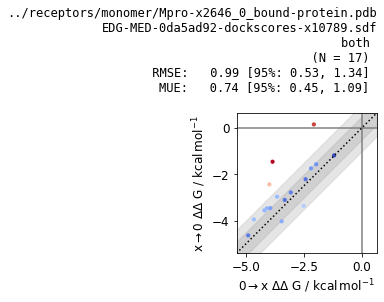

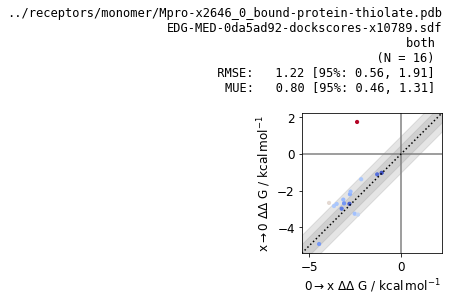

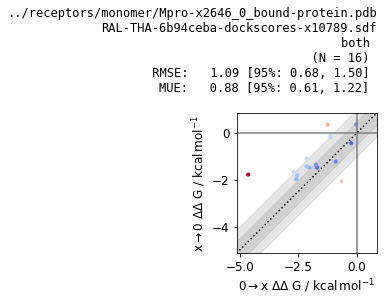

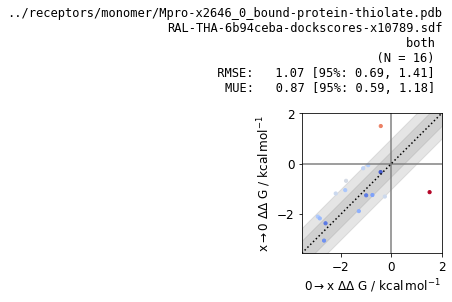

In [12]:
from beryllium import plotting, stats

to_delete = []

comb_graphs = [t for t in graphs if 'both' in t]
for t in comb_graphs:
    old_graph = graphs[t]
    graphs[(t[0],t[1],'comb')] = nx.DiGraph()
    r[(t[0],t[1],'comb')] = {}
    new_graph = graphs[(t[0],t[1],'comb')]
    x = []
    y = []
    for edge in old_graph.edges(data=True):
        if edge[0] == 0:
            if old_graph.has_edge(edge[1],edge[0]):
                x.append(edge[2]['calc_DDG'])
                y.append(-old_graph.get_edge_data(edge[1],edge[0])['calc_DDG'])
                DDG = 0.5*(edge[2]['calc_DDG']-old_graph.get_edge_data(edge[1],edge[0])['calc_DDG'])
                DDG_low = 0.5*(edge[2]['calc_DDG_low']-old_graph.get_edge_data(edge[1],edge[0])['calc_DDG_low']) # this isn't right 
                DDG_high = 0.5*(edge[2]['calc_DDG_high']-old_graph.get_edge_data(edge[1],edge[0])['calc_DDG_high']), # this isn't right
                new_graph.add_edge(edge[0],edge[1],
                               calc_DDG=DDG,
                               calc_DDG_low=DDG_low,
                               calc_DDG_high=DDG_high,
                               calc_dDDG=(edge[2]['calc_dDDG']**2+old_graph.get_edge_data(edge[1],edge[0])['calc_dDDG']**2)**0.5,
                               exp_DDG=0.,exp_dDDG=0.1)
                if edge[1] in r[(t[0],t[1], 'comb')]:
                    print(edge[1])
                else:
                    r[(t[0],t[1], 'comb')][edge[1]] = [DDG, DDG_low, DDG_high]

    if len(x) > 0 :
        plotting._master_plot(np.asarray(x), np.asarray(y),title=f"{t[0]}\n{t[1]}\n{t[2]}", xlabel=r'0$\rightarrow$x', ylabel=r'x$\rightarrow$0')
    to_delete.append(t)

for d in to_delete:
    del graphs[d]

In [13]:
def _get_best_number(ligand_result, n=10):
    '''
    This will return the best $N$ ligands from the set, where best is defined as lowest affinity
    
    ligand_result: dict(ligand_index: free energy)
        dictionary of ligand indices/titles/names to relative free energy compared to single point
    n: int, optional default=10
        number of ligands to return
        
    Returns
    -------
    
    list(tuple(ligand_index : free energy)) ### maybe we just want to return the sorted list of ligand indeces?
        
    '''
    assert len(ligand_result) < n , 'Fewer than n ({n}) ligands provided'
    return sorted(ligand_result.items(), key=lambda kv: kv[1])[0:n]

def _get_best_percent(ligand_result, p=10.):
    '''
    This will return the best p% ligands from the set, where best is defined as lowest affinity
    
    ligand_result: dict(ligand_index: free energy)
        dictionary of ligand indices/titles/names to relative free energy compared to single point
    p: float, optional default=10.
        percentage of dataset to return
        
    Returns
    -------
    
    list(tuple(ligand_index : free energy)) ### maybe we just want to return the sorted list of ligand indeces?
        
    '''
    assert 0. < p < 100., f'Percentage must be between 0 and 100 %, percentage {p} not in range'
    n = int(len(ligand_result) * (p/100))
    return sorted(ligand_result.items(), key=lambda kv: kv[1])[0:n]

def _get_better_than(ligand_result, threshold=0.):
    '''
    This will return all ligands with affinity lower than a threshold
    
    ligand_result: dict(ligand_index: free energy)
        dictionary of ligand indices/titles/names to relative free energy compared to single point
    threshold: float, optional default=0.
        will return all ligands with affinity better or equal to 0.0
        
    Returns
    -------
    
    list(tuple(ligand_index : free energy)) ### maybe we just want to return the sorted list of ligand indeces?
        
    '''
    return [(k,v) for k,v in ligand_result.items() if v[0] >= threshold]

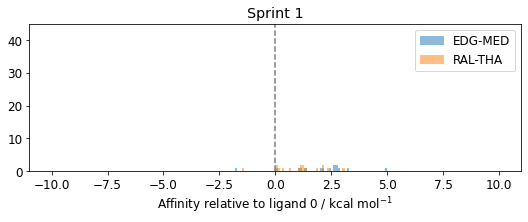

In [14]:
all_sets = []
bins = np.linspace(-10,10,201)
plt.figure(figsize=(7.5,3.25))
plot_labels = {'primary_amine_enumeration_for_chodera_lab_FEP-permuted-conformers-x10789.sdf':'Primary amines',
              'boronic_ester_enumeration_for_chodera_lab_FEP-permuted-conformers-x10789.sdf':'Boronic esters',
               'EDG-MED-0da5ad92-dockscores-x10789.sdf':'EDG-MED',
              'RAL-THA-6b94ceba-dockscores-x10789.sdf':'RAL-THA'}
for title, values in r.items():
    if title[2] == 'backwards' and title[0] == '../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb':
        all_sets.append([-x[0] for x in values.values()])
        plt.hist([-x[0] for x in values.values()],label=plot_labels[title[1]],bins=bins,alpha=0.5)
# plt.hist([item for sublist in all_sets for item in sublist],label='all',bins=bins,alpha=0.2,color='k')
plt.legend()
plt.title('Sprint 1')
plt.xlabel('Affinity relative to ligand 0 / '+r'kcal mol$^{-1}$')
plt.vlines(0.,0.,45.,color='grey',linestyle='dashed')
plt.ylim(0.,45.)
plt.tight_layout()

plt.savefig('/Users/brucemah/Desktop/distribution-sprint1.pdf')
plt.show()


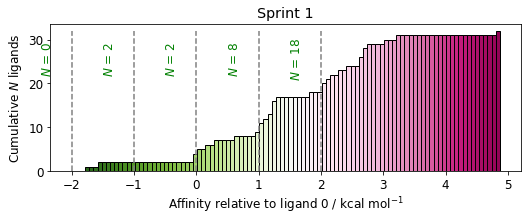

In [16]:
#### MATT - this is also just a plotting function
plt.figure(figsize=(7.5,3.25))
y_max = 5

### def plot_accumulative_affinity(numbers,n_bins=100,y_max=5.):
    # there are lots of very high affinity ligands, that we don't particularly care about, so use y_max to throw those away
ligand_result = [item for sublist in all_sets for item in sublist if item < y_max]
# subset = {k:v for k,v in ligand_result.items() if v < y_max}

# the colormap could be a kwarg
cm = plt.cm.get_cmap('PiYG')

# Get the histogramp
Y,X = np.histogram(list(ligand_result), 100)
Y = np.cumsum(Y)
# Y = np.log(Y)
x_span = X.max()-X.min()
C = [cm(((X.max()-x)/x_span)) for x in X]

plt.bar(X[:-1],Y,color=C,width=X[1]-X[0],edgecolor='k')

for v in range(-2,3):
    plt.vlines(-v,0,max(Y),'grey',linestyles='dashed')
    plt.text(v-0.5, 0.8*max(Y),f"$N$ = {len([x for x in ligand_result if x < v])}", rotation=90, verticalalignment='center',color='green')
plt.xlabel('Affinity relative to ligand 0 / '+r'kcal mol$^{-1}$')
plt.ylabel('Cumulative $N$ ligands')
plt.title('Sprint 1')
plt.tight_layout()
plt.savefig('/Users/brucemah/Desktop/cumulative-sprint1.pdf')
plt.show()

In [17]:
import mdtraj as md

def _find_lowest_work(work, run, proj='13420',forward=True):
    # work = dataframe
    # run is the 'RUNXX' as a string
    # proj is the project ID as a string
    # forward is True if we want to get the value for the NEW ligand
    # forward is False means backwards so that value for the OLD ligand
    # returns the strings of the integers for clone and gen, but could also just pass back the whole string as 'CLONEX' 'GENY'
    filter_works = work[(work['PROJ']==f'PROJ{proj}')]
    filter_works = filter_works[(filter_works['RUN']==run)]
    if forward == True:
        lowest_work_df = filter_works[filter_works.reverse_work == filter_works.forward_work.min()]
    else:
        lowest_work_df = filter_works[filter_works.reverse_work == filter_works.reverse_work.min()]

    # TODO there is no way that there isn't a better way to do this with pandas
    try:
        clone = list(lowest_work_df['CLONE'])[0]
        gen = list(lowest_work_df['GEN'])[0]
    except:
        print(f'something has gone wrong with {run}')
        return 0, 0
    return clone[5:], gen[3:]

def get_structure(proj,RUNID,GEN,CLONE,filename='',forwards=True,n_atoms=None):  
    ### TODO --- this will currently only work for looking at OLD ligands
    ### as we need to know the number of atoms to work out which correspond to the old ligand this is a hack
    ### really need the old_to_hybrid or new_to_hybrid mapping for this to work as it should
    
    # frame 0 is start ligand after EQUIL
    # 0 -> 1 NEQ
    # frame 1 is end ligand after NEQ
    # frame 2 is end ligand after EQ
    # 1 -> 0 NEQ
    # frame 3 is start ligand after NEQ
    
    # TODO - still not 100% sure this is exactly what we want
    if forwards:
        frame = 1
    else:
        frame = 3
        
    # RSYNC, or doing this as a batch might be faster
    try:
        os.system(f'scp server@aws3.foldingathome.org:/home/server/server2/projects/{proj}/RUNS/{RUNID}/*pdb {RUNID}.pdb')
        topology = md.load(f'{RUNID}.pdb').topology
    except OSError:
        print('no pdb file found')
        return None, None

    try:
        os.system(f'scp server@aws3.foldingathome.org:/home/server/server2/data/SVR314342810/PROJ{proj}/{RUNID}/CLONE{CLONE}/results{GEN}/*xtc pos_{RUNID}.xtc')
        traj = md.load_xtc(f'pos_{RUNID}.xtc',topology,frame=frame)
    except ValueError:
        print(f'error for clone {CLONE} gen {GEN}')
        return None, None
    except OSError:
        print('no xtc file found')
        return None, None
        

    # find the atom indices for the ligand (resname 'MOL')
    if n_atoms is not None:  
        atoms = [i for i in range(topology.n_atoms)]
        mol_ids = []
        for res in topology.residues:
            if res.name == 'MOL':
                for atom in res.atoms:
                    if len(mol_ids) < n_atoms:
                        mol_ids.append(atom.index)
                    else:
                        # removing the unique-new atoms, as they are the last in the list of the hybrid topology
                        # really need a way to do this for the other way
                        atoms.remove(atom.index)
        # this deletes the unique-new from traj in place
        traj.atom_slice(atoms, inplace=True)
    # this puts the protein:ligand in the center of the box
    traj.image_molecules()
    
    # removes solvent (i.e. the ions) as water isn't saved anyway
    traj.remove_solvent(inplace=True)
    
    # now save it
    traj.save_pdb(filename)

    mol_N = []
    mol_O = []
    his_N = []
    glu_N = []
    for residue in traj.topology.residues:
        if residue.name == 'MOL':
            for atom in residue.atoms:
                if str(atom.element) == 'nitrogen':
                    mol_N.append(atom.index)
                if str(atom.element) == 'oxygen':
                    mol_O.append(atom.index)
        elif residue.index == 166:
            for atom in residue.atoms:
                if str(atom.element) == 'nitrogen':
                    glu_N.append(atom.index)
        elif residue.index == 163:
            for atom in residue.atoms:
                if str(atom.element) != 'nitrogen':
                    his_N.append(atom.index)

    atom_pairs = []
    for i in mol_N:
        for j in his_N:
            atom_pairs.append((i,j))
    his_dist = min(md.compute_distances(traj, atom_pairs)[0])*10.


    atom_pairs = []
    for i in mol_O:
        for j in glu_N:
            atom_pairs.append((i,j))
    glu_dist = min(md.compute_distances(traj, atom_pairs)[0])*10.

    
    # now doing cleanup
    os.system(f'rm {RUNID}.pdb')
    os.system(f'rm pos_{RUNID}.xtc')
    
    return his_dist, glu_dist 

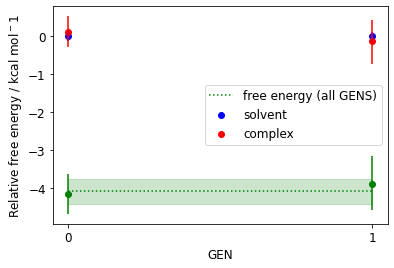

In [21]:
def plot_convergence(results, n_gens=3, title=None):
    if "complex_fes" in results and "solvent_fes" in results:
        max_gen = 0
        for i in range(n_gens):
            try:
                DDG = ((results[f"solvent_fes_GEN{i}"][0]- results[f"complex_fes_GEN{i}"][0])* kT).value_in_unit(unit.kilocalories_per_mole)
                low = ((results[f"solvent_fes_GEN{i}"][1]- results[f"complex_fes_GEN{i}"][2])* kT).value_in_unit(unit.kilocalories_per_mole)
                high = ((results[f"solvent_fes_GEN{i}"][2]- results[f"complex_fes_GEN{i}"][1])* kT).value_in_unit(unit.kilocalories_per_mole)
                plt.scatter(i, DDG, color='green')
                plt.vlines(i,low,high,color='green')
                if i > max_gen:
                    max_gen = i
            except KeyError:
                continue

        colors = {'solvent': 'blue', 'complex': 'red'}
        for phase in ['solvent', 'complex']:
            y = []
            low = []
            high = []
            for i in range(n_gens):
                try:
                    y.append((results[f"{phase}_fes_GEN{i}"][0] * kT)
                             .value_in_unit(unit.kilocalories_per_mole))
                    low.append((results[f"{phase}_fes_GEN{i}"][1] * kT)
                             .value_in_unit(unit.kilocalories_per_mole))
                    high.append((results[f"{phase}_fes_GEN{i}"][2] * kT)
                             .value_in_unit(unit.kilocalories_per_mole))
                    if i > max_gen:
                        max_gen = i
                except KeyError:
                    continue
            shift = np.mean(y)
            y = y - shift
            low = low - shift
            high = high - shift
            plt.scatter([i for i in range(0, max_gen+1)],  y,
                        color=colors[phase],label=phase)
            for i,_ in enumerate(y):
                plt.vlines(i,low[i],high[i],color=colors[phase])

        plt.xlabel('GEN')
        plt.ylabel('Relative free energy /'+r' kcal mol${^-1}$')
        plt.plot([0, max_gen],
                 [(results['binding_fe'][0]* kT).value_in_unit(unit.kilocalories_per_mole), (results['binding_fe'][0]* kT).value_in_unit(unit.kilocalories_per_mole)],
                 color='green', linestyle=":", label='free energy (all GENS)')
        plt.fill_between([0, max_gen],
                         (results['binding_fe'][1]* kT).value_in_unit(unit.kilocalories_per_mole),
                         (results['binding_fe'][2]* kT).value_in_unit(unit.kilocalories_per_mole),
                         alpha=0.2, color='green')
        plt.xticks([i for i in range(0, max_gen+1)])
        plt.legend()


plot_convergence(output['8474'])
plt.show()

In [22]:
# ### this will be useful for looking at looking at shift in relative FEs over GENS


# ### HBM --- we haven't had enough solvent GENS back for this to be useful so far, but maybe just plotting the complex free energies will give some insight into convergence, if not meaningful
# for d in output.values():
#     if len(d['complex_fes_GEN1']) > 0 and len(d['solvent_fes_GEN1']) > 0: # only interesting with more than one GEN done
#         for i in range(0,n_gens_run+1):
#             try:
#                 DDG = ((np.mean(d[f'complex_fes_GEN{i}']) - np.mean(d[f'solvent_fes_GEN{i}']))*kT).value_in_unit(unit.kilocalories_per_mole) 
#                 dDDG = ((np.mean(d[f'complex_dfes_GEN{i}'])**2 + np.mean(d[f'solvent_dfes_GEN{i}'])**2)**0.5*kT).value_in_unit(unit.kilocalories_per_mole)
#                 plt.errorbar(i, DDG,yerr=dDDG,color='hotpink')
#                 plt.scatter(i,DDG,color='hotpink')
#             except:
#                 continue
#         plt.xlabel('GEN')
#         plt.ylabel(r'$\Delta \Delta$G / kcal mol$^{-1}$')
#         plt.title(f'{d["start"]}'+r'$\rightarrow$'+f'{d["end"]}')
#         plt.show()


In [23]:
# ### this could be in a loop for each of the details['ligand'] there are
# from openforcefield.topology import Molecule
# molecules = Molecule.from_file('primary_amine_enumeration_for_chodera_lab_FEP-permuted-conformers.sdf',allow_undefined_stereo=True)
# from rdkit.Chem.Draw import IPythonConsole
        
# mol = molecules[0]
# mol.visualize(backend='openeye')

In [24]:
from openeye import oedepict
from openeye import oechem

def make_image_with_ligs(ligands,molecules,folder,filename):
    # ligands is the list of tuples of ligand NAME and free energy
    # molecules is the list of openforcefield.Topology.Molecules
    # filename is where to save it. pdf is better for zooming
    
    # this bit works out what size square the ligands can fit into
    n = len(ligands)
    sq = int(np.ceil(n**0.5)) # round up the square root of n_ligands
    
    
    # this will make a huge file if loads of ligands are passed in, so maybe some sort of scaling?
    image = oedepict.OEImage(sq*200, sq*200)

    rows, cols = sq,sq
    grid = oedepict.OEImageGrid(image, rows, cols)

    opts = oedepict.OE2DMolDisplayOptions(grid.GetCellWidth(), grid.GetCellHeight(),
                                           oedepict.OEScale_AutoScale)


    with open(f'{folder}/setup.pml','w') as f:    
        for (name,fe), cell in zip(sorted(ligands, key=lambda i: -float(i[1][0])), grid.GetCells()):
            for x in molecules:
                if x.name == name:
                    mol = x
            mol = mol.to_openeye()
            mol_name = mol.GetTitle()
            mol.SetTitle(f'{mol_name} {fe[0]:.1f} ({fe[1]:.1f}-{fe[2]:.1f})')
            oedepict.OEPrepareDepiction(mol)
            disp = oedepict.OE2DMolDisplay(mol, opts)
            oedepict.OERenderMolecule(cell, disp)
            f.write(f'load {mol_name}-{folder}.pdb \n')
        
        f.write(f'extra_fit resi [187-192,164-168,140-145], {mol_name}-{folder}, super, object=aln_super \n')   
        f.write('set cartoon_color, gray\n')
        f.write('hide spheres\n')
        f.write('hide (h. and (e. c extend 1))\n')
        f.write('set cartoon_transparency, 0.5 \n')
        f.write('sele ligands, resn MOL \n')
        f.write('sele GLU, resid 166 \n')
        f.write('sele HIS, resid 41 \n')
        f.write('show licorice, GLU \n')
        f.write('show licorice, HIS \n')
        f.write('orient ligands \n')
        f.write('delete aln_super \n')
        f.write('save ligands.sdf, ligands\n')
        f.write('bg_color white\n')        
    oedepict.OEWriteImage(f'{folder}/{filename}', image)

# make_image_with_ligs(best_amine_neutral_backwards,molecules,folder="neutral-buchwald",filename="BestNeutralBuchwald.pdf")
# make_image_with_ligs(best_amine_charged_backwards,molecules,folder="charged-buchwald",filename="BestChargedBuchwald.pdf")
                     
                     

In [25]:
ligands = {}
# ligand_index_to_name = {}

with bz2.BZ2File('../data/work-13420.pkl.bz2', 'r') as infile:
    work = pickle.load(infile)

In [ ]:
from openforcefield.topology import Molecule
from rdkit.Chem.Draw import IPythonConsole

for g in graphs.keys():
    if 'comb' in g:
        continue
    ligand = g[1]
    if ligand not in ligands:
        molecules = Molecule.from_file(f'../../covid-moonshot-new/synthetic-enumeration/{ligand}',allow_undefined_stereo=True)
        ligands[ligand] = molecules
    else:
        molecules = ligands[ligand]
    mol = molecules[0]
    mol.visualize(backend='openeye')
    r[g]['LIG(A-4000)'] = (0.,0.,0.)
    results = r[g]
    
    best_ligands_for_set = _get_better_than(results,threshold=0.05)
    if len(best_ligands_for_set) > 2:
        folder = ''
        if 'thiolate' in g[0]:
            folder += 'charged-'
        else:
            folder += 'neutral-'
        folder += g[1][0:13]
        folder += g[2]
        if isinstance(best_ligands_for_set[1][0], str):
            if not os.path.exists(folder):
                os.makedirs(folder)
            print(folder, len(best_ligands_for_set))
            make_image_with_ligs(best_ligands_for_set,ligands[ligand],filename=f'Best{folder}.pdf',folder=folder)
            
            #### 
            ligand_titles = [i[0] for i in best_ligands_for_set]
            print(ligand_titles)
            for d in output.values():
#                 print(d['start_smiles'])
                if g[2] == 'forwards':
                    break
                    # can't do this for now
                elif g[2] == 'backwards':
                    endstate = 'start_title'
                if d[endstate] in ligand_titles and g[1] == d['ligand'] and g[0] == d['protein']:
                    mol = None
                    for x in molecules:
                        if x.name == d[endstate]:
                            mol = x
                    if mol is None:
                        print('error with')
                    print(d['start_smiles'])
                    print(mol.to_smiles())
                    clone, gen = _find_lowest_work(work,d['directory'],forward=False)
                    his_dist, glu_dist = get_structure(13420,d['directory'],gen,clone,filename=f'{folder}/{mol.name}-{folder}.pdb',forwards=False,n_atoms=mol.n_atoms)                

                    if not os.path.isfile(f'{folder}/contacts.csv'):
                        with open(f'{folder}/contacts.csv','w') as f:
                            f.write(f'MOL, HIS163 (N-N), GLU166 (N-O), affinity, low, high\n')
                            if glu_dist is not None:
                                f.write(f'{mol.name}, {his_dist:.2f}, {glu_dist:.2f}, {results[mol.name][0]:.2f},{results[mol.name][1]:.2f}, {results[mol.name][2]:.2f} \n')
                            else:
                                f.write(f'{mol.name}, NA, NA, {results[mol.name][0]:.2f},{results[mol.name][1]:.2f}, {results[mol.name][2]:.2f} \n')

                    else:
                        with open(f'{folder}/contacts.csv','a') as f:
                            if glu_dist is not None:
                                f.write(f'{mol.name}, {his_dist:.2f}, {glu_dist:.2f}, {results[mol.name][0]:.2f},{results[mol.name][1]:.2f}, {results[mol.name][2]:.2f} \n')
                            else:
                                f.write(f'{mol.name}, NA, NA, {results[mol.name][0]:.2f},{results[mol.name][1]:.2f}, {results[mol.name][2]:.2f} \n')
                  

In [ ]:
from openforcefield.topology import Molecule
from rdkit.Chem.Draw import IPythonConsole

for g in graphs.keys():
    if 'comb' in g:
        continue
    ligand = g[1]
    if ligand not in ligands:
        molecules = Molecule.from_file(f'../../covid-moonshot-new/synthetic-enumeration/{ligand}',allow_undefined_stereo=True)
        ligands[ligand] = molecules
    else:
        molecules = ligands[ligand]
    mol = molecules[0]
    mol.visualize(backend='openeye')
#     r[g]['LIG(A-4000)'] = (0.,0.,0.)

    results = r[g]

    if 'RAL' in ligand:
        try:
            del r[g]['LIG(A-4000)']
        except KeyError:
            continue
        best_ligands_for_set = _get_better_than(results,threshold=-10.)
        folder = ''
        if 'thiolate' in g[0]:
            folder += 'charged-'
        else:
            folder += 'neutral-'
        folder += g[1][0:13]
        folder += g[2]
        if isinstance(best_ligands_for_set[1][0], str):
            if not os.path.exists(folder):
                os.makedirs(folder)
                print(folder, len(best_ligands_for_set))
            print([i[0] for i in best_ligands_for_set])
            print([mol.name for mol in ligands[ligand]])
            make_image_with_ligs(best_ligands_for_set,ligands[ligand],filename=f'Best{folder}.pdf',folder=folder)

            #### 
            ligand_titles = [i[0] for i in best_ligands_for_set]
            print(ligand_titles)
            for d in output.values():
                if g[2] == 'forwards':
                    continue
                    # can't do this for now
                elif g[2] == 'backwards':
                    endstate = 'start_title'
                if d[endstate] in ligand_titles and g[1] == d['ligand'] and g[0] == d['protein']:
                    mol = None
                    for x in molecules:
                        if x.name == d[endstate]:
                            mol = x
                    if mol is None:
                        print('error with')
                    clone, gen = _find_lowest_work(work,d['directory'],forward=False)
                    his_dist, glu_dist = get_structure(13420,d['directory'],gen,clone,filename=f'{folder}/{mol.name}-{folder}.pdb',forwards=False,n_atoms=mol.n_atoms)                

                    if not os.path.isfile(f'{folder}/contacts.csv'):
                        with open(f'{folder}/contacts.csv','w') as f:
                            f.write(f'MOL, HIS163 (N-N), GLU166 (N-O), affinity, low, high\n')
                            f.write(f'{mol.name}, {his_dist:.2f}, {glu_dist:.2f}, {results[mol.name][0]:.2f},{results[mol.name][1]:.2f}, {results[mol.name][2]:.2f} \n')
                    else:
                        with open(f'{folder}/contacts.csv','a') as f:
                            f.write(f'{mol.name}, {his_dist:.2f}, {glu_dist:.2f}, {results[mol.name][0]:.2f},{results[mol.name][1]:.2f}, {results[mol.name][2]:.2f} \n')                   


In [ ]:
mol = ligands['RAL-THA-6b94ceba-dockscores-x10789.sdf'][12]

# mol = molecules[0]
mol.visualize(backend='openeye')

In [ ]:
# results = r['amine-neutral']
# # l = results['DDG_f']
# # best_amine_neutral_forwards = _get_better_than(l,threshold=-1.)
# l = results['DDG_r']
# best_amine_neutral_backwards = _get_better_than(l,threshold=-1.)

# results = r['amine-charged']
# # l = results['DDG_f']
# # best_amine_charged_forwards = _get_better_than(l,threshold=-1.)
# l = results['DDG_r']
# best_amine_charged_backwards = _get_better_than(l,threshold=-1.)

In [ ]:
# mol = molecules[0]
# mol.visualize(backend='openeye')

In [ ]:
# index_to_name_amine = {}

# for d in details.values():
#     if d['end'] == 0 and 'amine' in d['ligand']:
#         index_to_name_amine[d['start']] = d['start_title']

In [ ]:
# make_image_with_ligs(best_amine_neutral_backwards,index_to_name_amine,molecules,folder="neutral-buchwald",filename="BestNeutralBuchwald.pdf")
# ligand_indices = [i[0] for i in best_amine_neutral_backwards]
# for d in details.values():
#     # backwards, buchwald and not charged
#     if d['start'] in ligand_indices and d['end'] == 0 and 'amine' in d['ligand'] and 'thiolate' not in d['protein']:
#         mol = None
#         for x in molecules:
#             if x.name == d['start_title']:
#                 mol = x
#         if mol is None:
#             print('error with')
#         print(d['directory'])
#         print(d['start_title'])
#         clone, gen = _find_lowest_work(work,d['directory'],forward=False)

#         get_structure(13420,d['directory'],gen,clone,filename=f'neutral-buchwald/{mol.name}-neutral-buchwald.pdb',forwards=False,n_atoms=mol.n_atoms)        

In [ ]:
# def generate_for_visual_inspection(best_list, index_to_name, molecules, details, folder="charged-buchwald",filename="BestChargedBuchwald.pdf"):
#     make_image_with_ligs(best_list,index_to_name_amine,molecules,folder="charged-buchwald",filename="BestChargedBuchwald.pdf")
#     ligand_indices = [i[0] for i in best_list]
#     for d in details.values():
#         # backwards, buchwald and charged
#         if d['start'] in ligand_indices and d['end'] == 0 and 'amine' in d['ligand'] and 'thiolate' in d['protein']:
#             mol = None
#             for x in molecules:
#                 if x.name == d['start_title']:
#                     mol = x
#             if mol is None:
#                 print('error with')

#             print(d['directory'])
#             print(d['start_title'])
#             clone, gen = _find_lowest_work(work,d['directory'],forward=False)
#             get_structure(13420,d['directory'],gen,clone,filename=f'charged-buchwald/{mol.name}-charged-buchwald.pdb',forwards=False,n_atoms=mol.n_atoms)            


In [ ]:
# make_image_with_ligs(best_amine_charged_backwards,index_to_name_amine,molecules,folder="charged-buchwald",filename="BestChargedBuchwald.pdf")
# print(len(best_amine_charged_backwards))
# ligand_indices = [i[0] for i in best_amine_charged_backwards]
# for d in details.values():
#     # backwards, buchwald and charged
#     if d['start'] in ligand_indices and d['end'] == 0 and 'amine' in d['ligand'] and 'thiolate' in d['protein']:
#         mol = None
#         for x in molecules:
#             if x.name == d['start_title']:
#                 mol = x
#         if mol is None:
#             print('error with')

#         print(d['directory'])
#         print(d['start_title'])
#         clone, gen = _find_lowest_work(work,d['directory'],forward=False)
#         get_structure(13420,d['directory'],gen,clone,filename=f'charged-buchwald/{mol.name}-charged-buchwald.pdb',forwards=False,n_atoms=mol.n_atoms)        

In [ ]:
# better_ligands = _get_better_than(ligand_result)
# plt.figure(figsize=(7.5,3))
# for i,(lig,val) in enumerate(sorted(ligand_result.items(), key=lambda kv: kv[1])):
#     if val-ligand_result_uncertainty[lig] < 0. < val+ligand_result_uncertainty[lig]:
#         plt.errorbar(i, val,yerr=ligand_result_uncertainty[lig],color='grey')
#     elif val+ligand_result_uncertainty[lig] < 0.:
#         plt.errorbar(i, val,yerr=ligand_result_uncertainty[lig],color='green')
#     else:
#         plt.errorbar(i, val,yerr=ligand_result_uncertainty[lig],color='red')
        
        
# plt.legendHandles[0].set_color('red')
# plt.legendHandles[1].set_color('yellow')
# plt.legend(['better','equal','worse'])
# plt.hlines(0,0,len(ligand_result),color='k',alpha=0.25)

# plt.show()

In [ ]:
# ### This is the complete repeat of above but with the Suzuki/Boronic set, but 100% code repetition so would be easy to tidy


# from openforcefield.topology import Molecule
# molecules = Molecule.from_file('../../covid-moonshot-new/synthetic-enumeration/boronic_ester_enumeration_for_chodera_lab_FEP-permuted-conformers-x10789.sdf',allow_undefined_stereo=True)
# from rdkit.Chem.Draw import IPythonConsole
        
# mol = molecules[0]
# mol.visualize(backend='openeye')


# index_to_name_boronic = {}

# for d in details.values():
#     if d['end'] == 0 and 'boronic' in d['ligand']:
#         index_to_name_boronic[d['start']] = d['start_title']

In [ ]:
# n = 36

# results = r['boronic-neutral']
# l = results['DDG_f']
# best_boronic_neutral_forwards = _get_better_than(l,threshold=-0.5)
# l = results['DDG_r']
# best_boronic_neutral_backwards = _get_better_than(l,threshold=-0.5)

# results = r['boronic-charged']
# l = results['DDG_f']
# best_boronic_charged_forwards = _get_better_than(l,threshold=-0.5)
# l = results['DDG_r']
# best_boronic_charged_backwards = _get_better_than(l,threshold=-0.5)



In [ ]:
#### TODO --- add ligand uncertainty into selection of 'best'

# from collections import Counter
# neutral_boronic = Counter([i[0] for i in best_boronic_neutral_backwards])
# with open('best_boronic_neutral.txt','w') as f:
#     for i in neutral_boronic:
#         f.write(f'{molecules[i].name}\n')

# charged_boronic = Counter([i[0] for i in best_boronic_charged_backwards])
# with open('best_boronic_charged.txt','w') as f:
#     for i in charged_boronic:
#         f.write(f'{molecules[i].name}\n')

# print(len(neutral_boronic))
        
# all_boronic = Counter([i[0] for i in best_boronic_neutral_backwards]+[i[0] for i in best_boronic_charged_forwards] + [i[0] for i in best_boronic_charged_backwards])
# with open('best_boronic_comb.txt','w') as f:
#     for i in all_boronic:
#         f.write(f'{molecules[i].name}, {all_amide[i]}\n')

In [ ]:
# make_image_with_ligs(best_boronic_neutral_backwards,index_to_name_boronic,molecules,folder="neutral-suzuki",filename="BestNeutralSuzuki.pdf")
# make_image_with_ligs(best_boronic_charged_backwards,index_to_name_boronic,molecules,folder="charged-suzuki",filename="BestChargedSuzuki.pdf")

In [ ]:
# # this is just nice to look at the occasional ligand
# mol = molecules[46]
# mol.visualize(backend='openeye')

In [ ]:
# make_image_with_ligs(best_boronic_neutral_backwards,index_to_name_boronic,molecules,folder="neutral-suzuki",filename="BestNeutralSuzuki.pdf")
# print(len(best_boronic_neutral_backwards))
# ligand_indices = [i[0] for i in best_boronic_neutral_backwards]
# for d in details.values():
#     # backwards, buchwald and charged
#     if d['start'] in ligand_indices and d['end'] == 0 and 'boron' in d['ligand'] and 'thiolate' not in d['protein']:
#         mol = None
#         for x in molecules:
#             if x.name == d['start_title']:
#                 mol = x
#         if mol is None:
#             print('error with')

#         print(d['directory'])
#         print(d['start_title'])
#         clone, gen = _find_lowest_work(work,d['directory'],forward=False)
#         get_structure(13420,d['directory'],gen,clone,filename=f'neutral-suzuki/{mol.name}-neutral-suzuki.pdb',forwards=False,n_atoms=mol.n_atoms)        

In [ ]:
# make_image_with_ligs(best_boronic_charged_backwards,index_to_name_boronic,molecules,folder="charged-suzuki",filename="BestChargedSuzuki.pdf")
# print(len(best_boronic_charged_backwards))
# ligand_indices = [i[0] for i in best_boronic_charged_backwards]
# for d in details.values():
#     # backwards, buchwald and charged
#     if d['start'] in ligand_indices and d['end'] == 0 and 'boron' in d['ligand'] and 'thiolate' in d['protein']:
#         mol = None
#         for x in molecules:
#             if x.name == d['start_title']:
#                 mol = x
#         if mol is None:
#             print('error with')

#         print(d['directory'])
#         print(d['start_title'])
#         clone, gen = _find_lowest_work(work,d['directory'],forward=False)
#         count = ''
#         filename = f'charged-suzuki/{mol.name}-charged-suzuki.pdb'
#         num_repeats = len([x for x in os.listdir(f'charged-suzuki/') if mol.name in x])
#         if num_repeats > 0:
#             filename = f'charged-suzuki/{mol.name}-charged-suzuki{num_repeats}.pdb'
#         get_structure(13420,d['directory'],gen,clone,filename=filename,forwards=False,n_atoms=mol.n_atoms)        
        
        
        
        

In [ ]:
# for mol in molecules:
#     if mol.name == 'EN300-359811':
# #         print(dir(mol)) 
#         print(mol.to_smiles())

In [ ]:
# print(len(molecules))

# print(len(set([mol.to_smiles() for mol in molecules])))

In [ ]:
# os.listdir(f'charged-suzuki/')
# len([x for x in os.listdir(f'charged-suzuki/') if mol.name in x])

### looking at redundant molecules (i.e. same smiles)

In [ ]:
# c = Counter([mol.to_smiles() for mol in molecules])

# fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5),sharey=True)
# for lig, (smi, count) in enumerate(c.most_common()):
#     if count > 1:
#         xlabels.append(smi)
#         for mol in molecules:
#             if mol.to_smiles() == smi:
#                 for d in details.values():
#                     try:
#                         if d['start_title'] == mol.name:
#                             if 'thiolate' in d['protein']:
#                                 ax = 1
#                             else:
#                                 ax = 0
#                             axes[ax].scatter(lig, d["DDG"],color='red',alpha=0.5)
#                             axes[ax].errorbar(lig, d["DDG"],yerr=d["dDDG"],color='red',alpha=0.5)
#                     except KeyError:
#                             continue
# axes[1].set_title('charged')
# axes[0].set_title('neutral')
# axes[0].set_xticks(range(0,3))
# axes[1].set_xticks(range(0,3))
# axes[0].set_ylabel('relative free energy /'+r' kcal mol$^{-1}$')
# plt.show()

In [ ]:
### BUYING LIST AUGUST 14th

buchwald = ['EN300-60314',
'EN300-6734624',
'EN300-20814457',
'EN300-1723947',
'EN300-2515954',
'EN300-6734624', 
'EN300-124496',
'EN300-212829'] # — shifting backbone a lot


suzuki = ['EN300-26624333',
'EN300-365771',
'EN300-316592',
'EN300-298506',
'EN300-1086686',
'EN300-106778',
'EN300-1425849',
'EN300-1704613',
'EN300-299518']

In [ ]:



make_image_with_ligs(buchwald,ligands['primary_amine_enumeration_for_chodera_lab_FEP-permuted-conformers-x10789.sdf'],folder='.',filename='purchasingAug14.pdf')

In [ ]:
from openeye import oedepict
from openeye import oechem

def make_purchased_image(ligands,molecules,folder,filename):
    # ligands is the list of tuples of ligand NAME and free energy
    # molecules is the list of openforcefield.Topology.Molecules
    # filename is where to save it. pdf is better for zooming
    
    # this bit works out what size square the ligands can fit into
    n = len(ligands)
    sq = int(np.ceil(n**0.5)) # round up the square root of n_ligands
    
    
    # this will make a huge file if loads of ligands are passed in, so maybe some sort of scaling?
    image = oedepict.OEImage(sq*200, sq*200)

    rows, cols = sq,sq
    grid = oedepict.OEImageGrid(image, rows, cols)

    opts = oedepict.OE2DMolDisplayOptions(grid.GetCellWidth(), grid.GetCellHeight(),
                                           oedepict.OEScale_AutoScale)


#     with open(f'{folder}/setup.pml','w') as f:    
    for name, cell in zip(ligands, grid.GetCells()):
        for x in molecules:
            if x.name == name:
                mol = x
        mol = mol.to_openeye()
        mol_name = mol.GetTitle()
#             mol.SetTitle(f'{mol_name}\n{fe[0]:.1f} ({fe[1]:.1f}-{fe[2]:.1f})')
        oedepict.OEPrepareDepiction(mol)
        disp = oedepict.OE2DMolDisplay(mol, opts)
        oedepict.OERenderMolecule(cell, disp)
    oedepict.OEWriteImage(f'{filename}', image)

# make_image_with_ligs(best_amine_neutral_backwards,molecules,folder="neutral-buchwald",filename="BestNeutralBuchwald.pdf")
# make_image_with_ligs(best_amine_charged_backwards,molecules,folder="charged-buchwald",filename="BestChargedBuchwald.pdf")
                     
        

In [ ]:
make_purchased_image(buchwald,ligands['primary_amine_enumeration_for_chodera_lab_FEP-permuted-conformers-x10789.sdf'],folder='.',filename='purchasingBuchwaldAug14.pdf')

make_purchased_image(suzuki,ligands['boronic_ester_enumeration_for_chodera_lab_FEP-permuted-conformers-x10789.sdf'],folder='.',filename='purchasingSuzukiAug14.pdf')



In [ ]:
ligands.keys()